In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
%matplotlib widget

import importlib
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf


In [2]:
importlib.reload(ExperimentClass)
importlib.reload(tools)
importlib.reload(mf)

<module 'math_functions' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\math_functions.py'>

In [5]:
manip = ExperimentClass.Experiment("20240716_activation_phiPS2_WT4A_control_1","PSI", DataType=".csv", sep = ';')
#Intensities = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]
Intensities = [0, 26.9, 93.1, 157.4, 232.5, 365.5, 591.3]
condition = 'WT4A control'

C:\Users\Orlando\AppData\Local\Temp\ipykernel_27248\3222298064.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno', len(act))


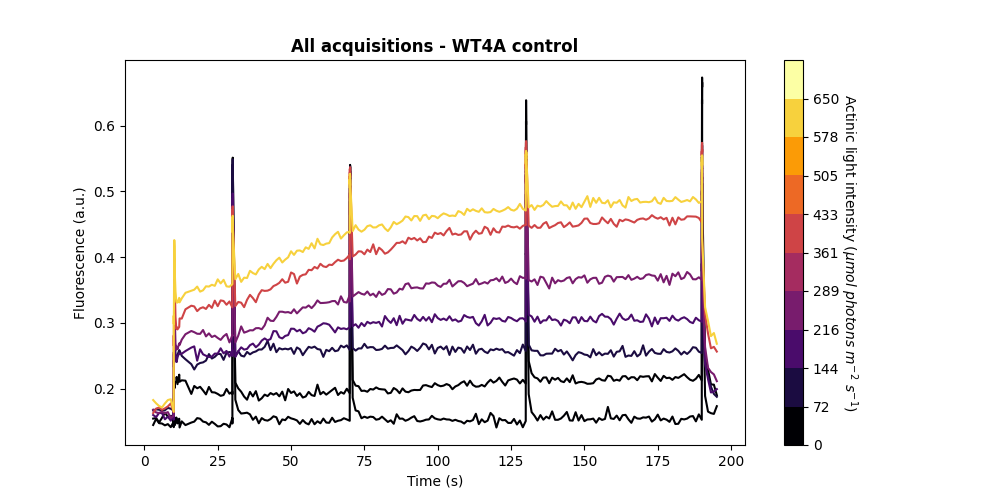

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
act = np.linspace(0, max(Intensities)*1.1, 10)
cmap = plt.cm.get_cmap('inferno', len(act))
for i, k in enumerate(manip.records[::-1]):
    ax.plot(manip.Time, manip.Data[k], color = cmap(tools.closest_index(act,Intensities[i])), label = f"{Intensities[i]}%")

cmap_legend = True
if cmap_legend:
# add cmap legend
    sm = ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(act)), cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=range(len(act)), ax = ax)
    cbar.ax.set_yticklabels([f'{int(label)}' for label in act])
    cbar.ax.set_ylabel('Actinic light intensity ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)', rotation=270, labelpad=15)
else:
    ax.legend(title = "Actinic light intensity", loc = 'upper left', borderaxespad = 3)
    fig.set_figwidth(10)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title(f'All acquisitions - {condition}', fontweight = 'bold')

fig.savefig(f"{manip.fig_folder}/All_acquisitions.png", dpi=300)


In [7]:
test = []
test.append([])
test[0]


[]

In [8]:
def compute_params(Experiment_df, Intensities, times_Fmax ):
    
    t_F0 = [0, 9]                  # time interval for F0 calculation in seconds
    t_Fstat = [-12, -0.5]              # time interval for Fstat calculation in seconds RELATIVE TO F_MAX!!!
    t_Fmax = [0.1, 0.12]       # time interval for Fmax_OJ calculation in seconds RELATIVE TO F_MAX!!!
    
    F_max = []
    F_stat = []
    F_0 = []
    phi_stat = []
    phi_0 = []
    NPQ = []
    ETR = []

    for i, k in enumerate(Experiment_df.records[::-1]):
        F_0.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_F0[0])[0][0] :np.where(Experiment_df.Time>= t_F0[1])[0][0]]))
        aux_F_max = []
        aux_F_stat = []
        aux_phi_stat = []
        aux_ETR = []
        aux_NPQ = []        
        for j, t in enumerate(times_Fmax):
            aux_F_max.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_Fmax[0] + t)[0][0] :np.where(Experiment_df.Time>= t_Fmax[1] + t)[0][0]]))
            aux_F_stat.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_Fstat[0] + t)[0][0] :np.where(Experiment_df.Time>= t_Fstat[1] + t)[0][0]]))
            aux_phi_stat.append((aux_F_max[j] - aux_F_stat[j]) / aux_F_max[j])
            aux_ETR.append(aux_phi_stat[j] * Intensities[i])
            if i == 0:
                aux_NPQ.append((aux_F_max[0] - aux_F_max[j])/aux_F_max[j])
            else:
                aux_NPQ.append((F_max[0][0] - aux_F_max[j])/aux_F_max[j])
        F_max.append(aux_F_max)
        F_stat.append(aux_F_stat)
        phi_stat.append(aux_phi_stat)
        ETR.append(aux_ETR)
        NPQ.append(aux_NPQ)

        phi_0.append((F_max[i][0] - F_0[i]) / F_max[i][0])
        
    norm = F_max[0][0]
    
    F_max = list(np.array(F_max)/norm)
    F_stat = list(np.array(F_stat)/norm)
    F_0 = list(np.array(F_0)/norm)
        
    params_df = pd.DataFrame({'Record': Experiment_df.records[::-1], 'Actinic': Intensities, 'F_max': F_max, 'F_stat': F_stat,
                              'F_0': F_0, 'phi_stat': phi_stat, 'phi_0': phi_0, 'NPQ': NPQ, 'ETR': ETR})
    
    return params_df, norm
    

In [9]:
times_Fmax = [30, 70, 130, 190]
params_df, norm = compute_params(manip, Intensities, times_Fmax)

In [10]:
np.asarray(params_df.F_max.tolist())[:,0]

array([1.        , 0.87962123, 0.99541603, 0.89800306, 0.87077874,
       0.86080861, 0.83531806])

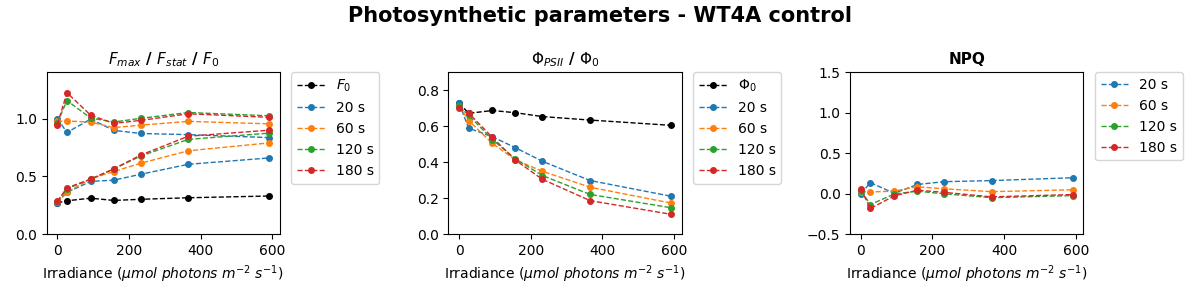

In [16]:
fig, ax = plt.subplots(1,3, figsize = (12,3))
fig.suptitle(f"Photosynthetic parameters - {condition}", fontsize = 15, fontweight = 'bold')
line = 1
marker = 4

ax[0].plot(params_df.Actinic, params_df.F_0, 'o--', markersize = marker, linewidth = line, color = 'k', label = '$F_{0}$')
ax[1].plot(params_df.Actinic, params_df.phi_0, 'o--', markersize = marker, linewidth = line, color = 'k', label = '$Φ_{0}$')
ax[0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$', fontsize = 11, fontweight = 'bold')
ax[0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$', fontsize = 11, fontweight = 'bold')
ax[1].set_title('$Φ_{PSII}$ / $Φ_{0}$', fontsize = 11, fontweight = 'bold')
ax[2].set_title('NPQ', fontsize = 11, fontweight = 'bold')
ax = ax.flatten() 
[ax.set_xlabel("Irradiance ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)", fontsize = 10) for ax in ax]

ax[0].set_ylim(0, 1.4)
ax[1].set_ylim(0, 0.9)
ax[2].set_ylim(-0.5, 1.5)


for i in range(len(times_Fmax)):
    ax[0].plot(params_df.Actinic, np.asarray(params_df.F_max.tolist())[:,i], 'o--', markersize = marker, linewidth = line, color = f"C{i}", label = f"{times_Fmax[i]-10} s")
    ax[0].plot(params_df.Actinic, np.asarray(params_df.F_stat.tolist())[:,i], 'o--', markersize = marker, linewidth = line, color = f"C{i}")
    ax[1].plot(params_df.Actinic, np.asarray(params_df.phi_stat.tolist())[:,i], 'o--', markersize = marker, linewidth = line, label = f"{times_Fmax[i]-10} s", color = f"C{i}")
    ax[2].plot(params_df.Actinic, np.asarray(params_df.NPQ.tolist())[:,i], 'o--', markersize = marker, linewidth = line, label = f"{times_Fmax[i]-10} s", color = f"C{i}")

[ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) for ax in ax]
fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/Parameters.png", dpi=300)

In [17]:
ETR_matrix = np.asarray(params_df.ETR.tolist())
ETR_matrix.shape

(7, 4)

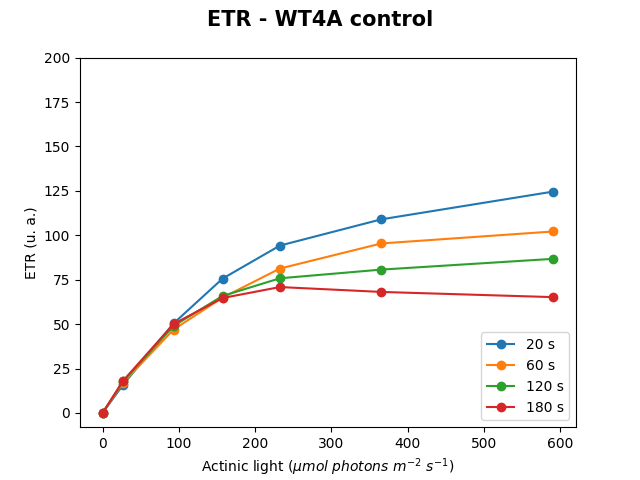

In [18]:

light = params_df.Actinic.tolist()
ETR_matrix = np.asarray(params_df.ETR.tolist())

fig, ax = plt.subplots()
fig.suptitle(f"ETR - {condition}", fontsize = 15, fontweight = 'bold')
for i in range(len(times_Fmax)):
    ETR = ETR_matrix[:,i]
    ax.plot(light, ETR, 'o-', label = f"{times_Fmax[i]-10} s", color = f"C{i}")
ax.legend(loc = 'lower right')
ax.set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax.set_ylabel("ETR (u. a.)")
ax.set_ylim(-8, 200)


fig.savefig(f"{manip.fig_folder}/ETR_points.png", dpi=300)

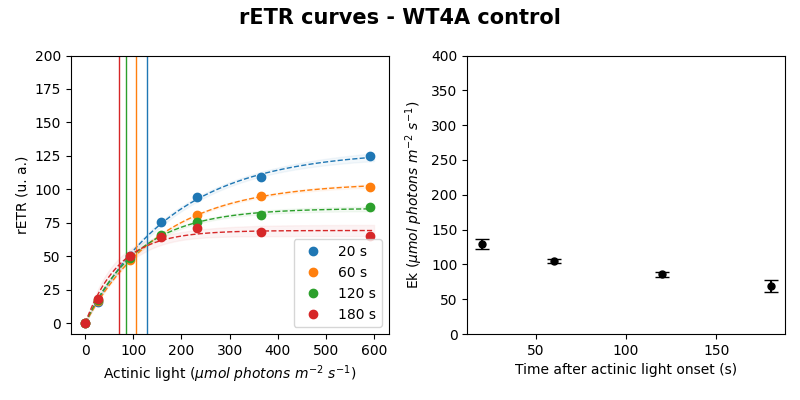

In [19]:

light = params_df.Actinic.tolist()
ETR_matrix = np.asarray(params_df.ETR.tolist())

fig, ax = plt.subplots(1,2, figsize = (8,4))
fig.suptitle(f"rETR curves - {condition}", fontsize = 15, fontweight = 'bold')

Ek = []
Ek_err = []

for i in range(len(times_Fmax)):
    ETR = ETR_matrix[:,i]
    ax[0].plot(light, ETR, 'o', label = f"{times_Fmax[i]-10} s", color = f"C{i}")
    popt, pcov, xfit, yfit = tools.Ek_fit(light, ETR, 0, 600, 100, p0 = [100, 100])
    err = tools.my_err(xfit, popt, pcov, mf.Ek)
    ax[0].fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = f"C{i}")
    ax[0].plot(xfit, yfit, '--', color =f"C{i}", linewidth = 1)
    Ek.append(popt[0])
    Ek_err.append(np.sqrt(np.diag(pcov))[1])

    ax[0].axvline(x=Ek[i], color=f"C{i}", linewidth=1)


    
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax[0].set_ylabel("rETR (u. a.)")
ax[0].set_ylim(-8, 200)

ax[1].errorbar(np.array(times_Fmax)-10, Ek, yerr = Ek_err, fmt = 'o', color = 'k', capsize = 5, markersize = 5)
ax[1].set_xlabel("Time after actinic light onset (s)")
ax[1].set_ylabel("Ek ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax[1].set_ylim(0, 400)

fig.tight_layout()
fig.savefig(f"{manip.fig_folder}/ETR.png", dpi=300)

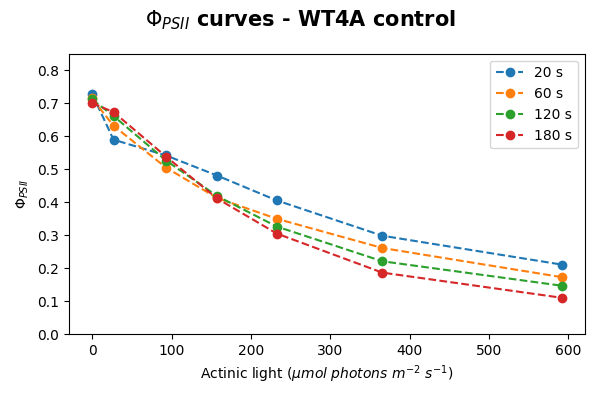

In [20]:
light = params_df.Actinic.tolist()
Phi_PS2_matrix = np.asarray(params_df.phi_stat.tolist())

fig, ax = plt.subplots(figsize = (6,4))
fig.suptitle(f"$Φ_{{PSII}}$ curves - {condition}", fontsize = 15, fontweight = 'bold')
for i in range(len(times_Fmax)):
    Phi_PS2 = Phi_PS2_matrix[:,i]
    ax.plot(light, Phi_PS2, '--o', label = f"{times_Fmax[i]-10} s", color = f"C{i}")
ax.legend()
ax.set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax.set_ylabel("$Φ_{PSII}$")
ax.set_ylim(0, 0.85)
fig.tight_layout()
fig.savefig(f"{manip.fig_folder}/Phi_PS2.png", dpi=300)

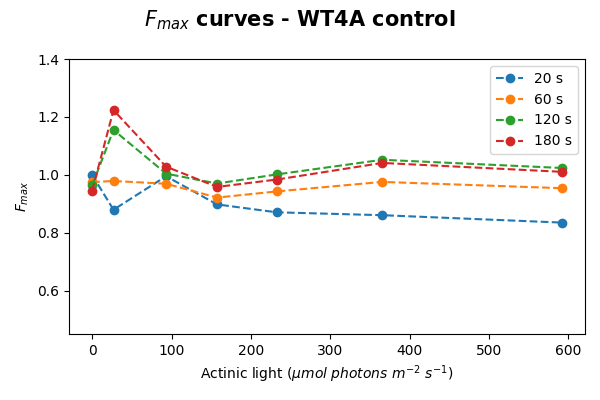

In [23]:
light = params_df.Actinic.tolist()
F_max_matrix = np.asarray(params_df.F_max.tolist())

fig, ax = plt.subplots(figsize = (6,4))
fig.suptitle(f"$F_{{max}}$ curves - {condition}", fontsize = 15, fontweight = 'bold')
for i in range(len(times_Fmax)):
    F_max = F_max_matrix[:,i]
    ax.plot(light, F_max, '--o', label = f"{times_Fmax[i]-10} s", color = f"C{i}")
ax.legend()
ax.set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax.set_ylabel("$F_{max}$")
ax.set_ylim(0.45, 1.4)
fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/F_max.png", dpi=300)


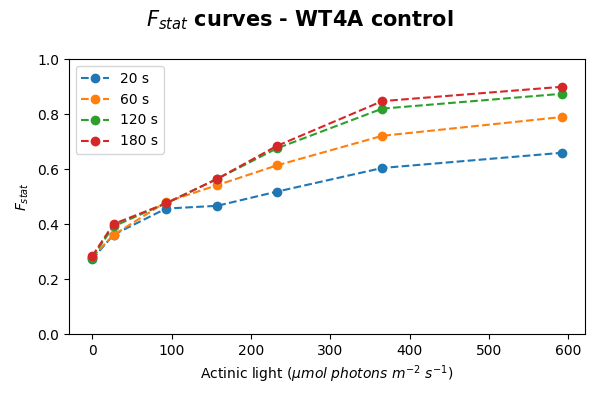

In [25]:
light = params_df.Actinic.tolist()
F_stat_matrix = np.asarray(params_df.F_stat.tolist())

fig, ax = plt.subplots(figsize = (6,4))
fig.suptitle(f"$F_{{stat}}$ curves - {condition}", fontsize = 15, fontweight = 'bold')
for i in range(len(times_Fmax)):
    F_stat = F_stat_matrix[:,i]
    ax.plot(light, F_stat, '--o', label = f"{times_Fmax[i]-10} s", color = f"C{i}")
ax.legend()
ax.set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax.set_ylabel("$F_{stat}$")
ax.set_ylim(0, 1)
fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/F_stat.png", dpi=300)

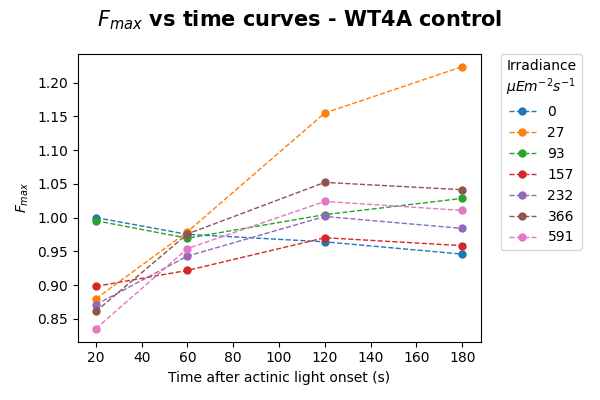

In [26]:
light = params_df.Actinic.tolist()
F_max_matrix = np.asarray(params_df.F_max.tolist())

fig, ax = plt.subplots(figsize = (6,4))
fig.suptitle(f"$F_{{max}}$ vs time curves - {condition}", fontsize = 15, fontweight = 'bold')
for i in range(len(light)):
    F_stat = F_max_matrix[i,:]
    ax.plot(np.array(times_Fmax) - 10, F_stat, '--o', label = f"{light[i]:.0f}", color = f"C{i}", markersize = 5, linewidth = 1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title = "Irradiance\n$µE$$m^{-2}$$s^{-1}$")
ax.set_xlabel("Time after actinic light onset (s)")
ax.set_ylabel("$F_{max}$")
fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/F_max_time.png", dpi=300)

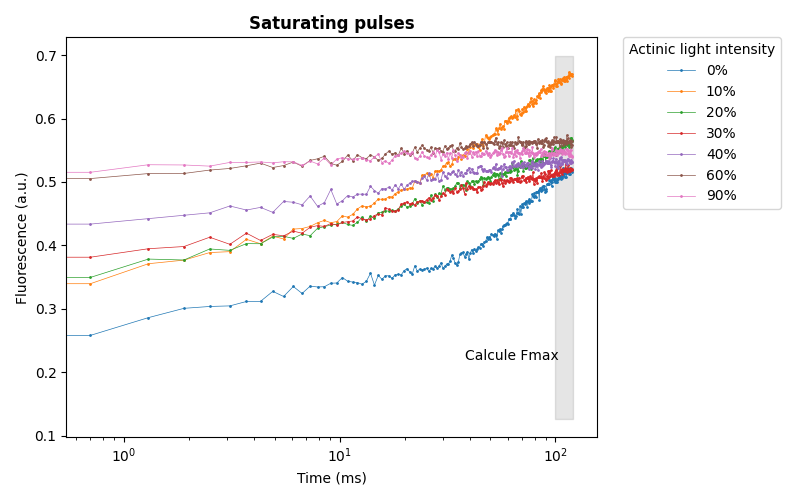

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
start = tools.closest_index(manip.Time, 190)
end = tools.closest_index(manip.Time, 190.12)
time = (manip.Time[start:end]-manip.Time[start])*1000
for i, k in enumerate(manip.records[::-1]):
    ax.semilogx(time, manip.Data[k][start:end], 'o-', markersize = 1, linewidth = 0.5, label = f"{Intensities[i]}%")

ylim = ax.get_ylim()
#ax.fill_betweenx(ylim, 4, 7, color = 'k', alpha = 0.1)
ax.fill_betweenx(ylim, 100, 120, color = 'k', alpha = 0.1)
ax.legend(title = "Actinic light intensity", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#ax.text(3, 0.22, "Calcule Fmax OJ", fontsize = 10)
ax.text(38, 0.22, "Calcule Fmax", fontsize = 10)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title('Saturating pulses', fontweight = 'bold')
fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/Sat_pulse_log.png", dpi=300)


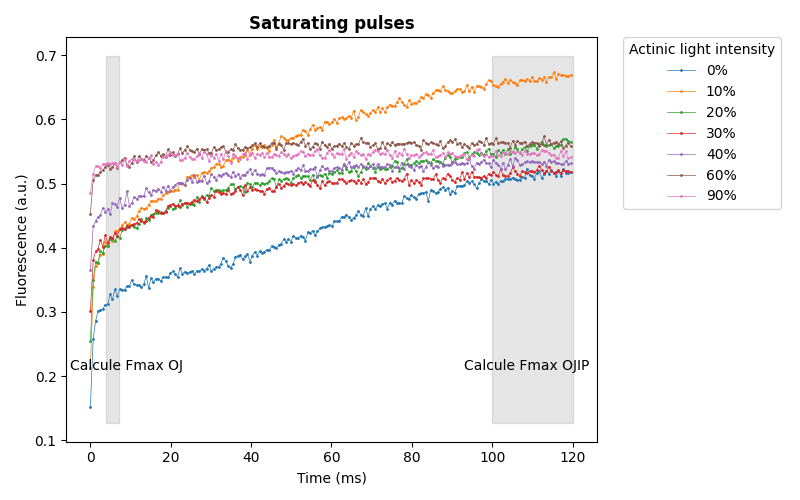

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
start = tools.closest_index(manip.Time, 190)
end = tools.closest_index(manip.Time, 190.12)
time = (manip.Time[start:end]-manip.Time[start])*1000
for i, k in enumerate(manip.records[::-1]):
    ax.plot(time, manip.Data[k][start:end], 'o-', markersize = 1, linewidth = 0.5, label = f"{Intensities[i]}%")

ylim = ax.get_ylim()
ax.fill_betweenx(ylim, 4, 7, color = 'k', alpha = 0.1)
ax.fill_betweenx(ylim, 100, 120, color = 'k', alpha = 0.1)
ax.legend(title = "Actinic light intensity", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.text(-5, 0.21, "Calcule Fmax OJ", fontsize = 10)
ax.text(93, 0.21, "Calcule Fmax OJIP", fontsize = 10)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title('Saturating pulses', fontweight = 'bold')
fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/Sat_pulse.png", dpi=300)
